In [1]:
# ==========================================
# AI PRODUCT MVP: PREDICTIVE MAINTENANCE
# Role: AI Product Manager / Data Scientist
# Context: Building Technologies (HVAC/Motors)
# ==========================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

# ---------------------------------------------------------
# 1. DATA INGESTION (Simulating the Data Lake)
# ---------------------------------------------------------
# We will use the AI4I 2020 Predictive Maintenance Dataset URL directly
# If this link fails, download 'ai4i2020.csv' from UCI/Kaggle
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"

print("Loading data from sensor network...")
try:
    df = pd.read_csv(url)
    print(f"Data Loaded Successfully directly from the source URL: {df.shape[0]} records, {df.shape[1]} features")
except:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SideProject-AnomalyDetection/ai4i2020.csv')
    print("Successfully loading data from the manual import of the local file.")

Loading data from sensor network...
Data Loaded Successfully directly from the source URL: 10000 records, 14 features


In [2]:
# ---------------------------------------------------------
# 2. PRODUCT DATA CLEANING & FEATURE SELECTION
# ---------------------------------------------------------
# Rename columns for business clarity
df.rename(columns={
    'Air temperature [K]': 'Air_Temp',
    'Process temperature [K]': 'Process_Temp',
    'Rotational speed [rpm]': 'RPM',
    'Torque [Nm]': 'Torque',
    'Tool wear [min]': 'Wear_Time',
    'Machine failure': 'Actual_Failure'
}, inplace=True)

# Select features relevant to the physical health of the machine
features = ['Air_Temp', 'Process_Temp', 'RPM', 'Torque', 'Wear_Time']
X = df[features]

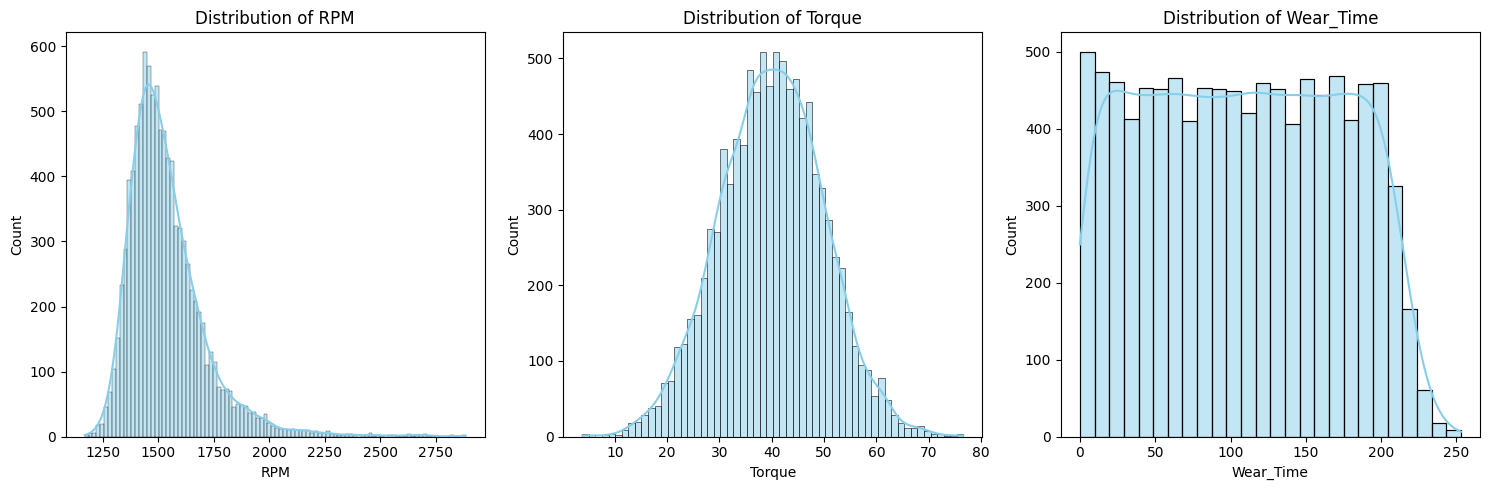

In [3]:
# ---------------------------------------------------------
# 3. EXPLORATORY ANALYSIS (The "Health Check")
# ---------------------------------------------------------
# PM Insight: We need to understand what "Normal" looks like before finding anomalies.
plt.figure(figsize=(15, 5))
for i, col in enumerate(['RPM', 'Torque', 'Wear_Time']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [4]:
# ---------------------------------------------------------
# 4. MODEL DEVELOPMENT: VARIOUS OPTIONS TO BE SELECTED
# Comparison: Isolation Forest vs. OCSVM vs. LOF
# ---------------------------------------------------------

# Scaling is important for distance/density based models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the Experiment Parameters
# Contamination is our "Guess" of how many machines are broken (approx 3.4% in this dataset)
CONTAMINATION = 0.034
RANDOM_STATE = 42

models = {
    "Isolation Forest": IsolationForest(n_estimators=100, contamination=CONTAMINATION, random_state=RANDOM_STATE),
    "One-Class SVM": OneClassSVM(nu=CONTAMINATION, kernel="rbf", gamma='scale'),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=CONTAMINATION)
}

results = []

print(f"\n⚡ STARTING BENCHMARKING (Contamination set to {CONTAMINATION*100}%) ...\n")


⚡ STARTING BENCHMARKING (Contamination set to 3.4000000000000004%) ...



In [5]:
# ---------------------------------------------------------
# 5. RUNNING THE THREE MODELS
# ---------------------------------------------------------
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()

    # LOF has a different API structure in sklearn (fit_predict)
    if name == "Local Outlier Factor":
        y_pred = model.fit_predict(X_scaled)
    else:
        model.fit(X_scaled)
        y_pred = model.predict(X_scaled)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
    y_pred_binary = [1 if x == -1 else 0 for x in y_pred]

    # Calculate Metrics against Ground Truth (Actual_Failure)
    recall = recall_score(df['Actual_Failure'], y_pred_binary)
    precision = precision_score(df['Actual_Failure'], y_pred_binary)
    f1 = f1_score(df['Actual_Failure'], y_pred_binary)

    results.append({
        "Model": name,
        "Training Time (sec)": round(elapsed_time, 4),
        "Recall (Catch Rate)": round(recall, 3),
        "Precision (Reliability)": round(precision, 3),
        "F1 Score": round(f1, 3)
    })

Training Isolation Forest...
Training One-Class SVM...
Training Local Outlier Factor...


In [6]:
# ---------------------------------------------------------
# 6. RESULTS TABLE FROM THE PREVIOUS TRAINING
# ---------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n FINAL SCORECARD:")
print(results_df.to_string(index=False))


 FINAL SCORECARD:
               Model  Training Time (sec)  Recall (Catch Rate)  Precision (Reliability)  F1 Score
    Isolation Forest               0.6581                0.168                    0.168     0.168
       One-Class SVM               1.1887                0.286                    0.284     0.285
Local Outlier Factor               0.7287                0.251                    0.250     0.250


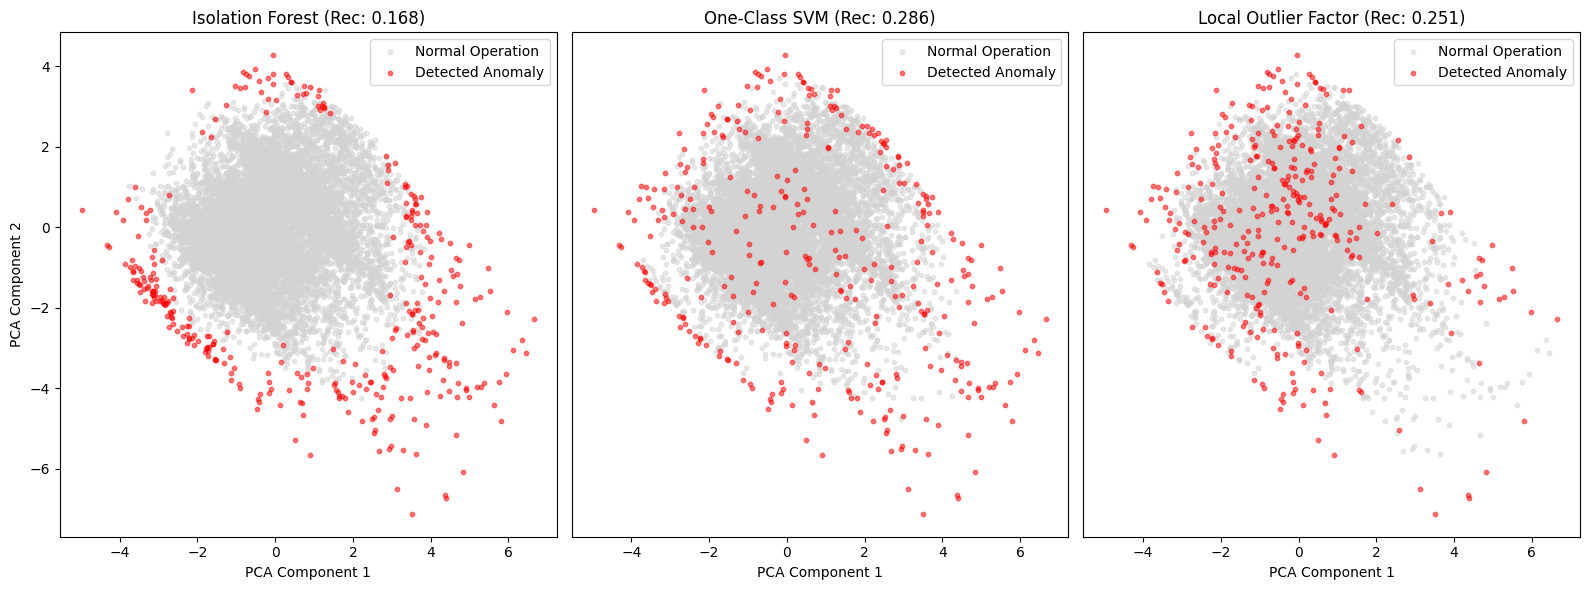

In [19]:
# ---------------------------------------------------------
# 7. VISUALIZING THE DIFFERENCE (PCA 2D PROJECTION)
# ---------------------------------------------------------
# Let's see how they differ visually. We'll plot the "Predicted Failures" for the 3 models.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(16, 6))

# Plot for Isolation Forest
plt.subplot(1, 3, 1)
y_pred_if = models['Isolation Forest'].predict(X_scaled)
plt.scatter(X_pca[y_pred_if == 1, 0], X_pca[y_pred_if == 1, 1], c='lightgrey', s=10, alpha=0.5, label='Normal Operation')
plt.scatter(X_pca[y_pred_if == -1, 0], X_pca[y_pred_if == -1, 1], c='red', s=10, alpha=0.5, label='Detected Anomaly')
plt.title(f"Isolation Forest (Rec: {results[0]['Recall (Catch Rate)']})")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot for One-Class SVM
plt.subplot(1, 3, 2)
y_pred_svm = models['One-Class SVM'].predict(X_scaled)
plt.scatter(X_pca[y_pred_svm == 1, 0], X_pca[y_pred_svm == 1, 1], c='lightgrey', s=10, alpha=0.5, label='Normal Operation')
plt.scatter(X_pca[y_pred_svm == -1, 0], X_pca[y_pred_svm == -1, 1], c='red', s=10, alpha=0.5, label='Detected Anomaly')
plt.title(f"One-Class SVM (Rec: {results[1]['Recall (Catch Rate)']})")
plt.xlabel('PCA Component 1')
plt.yticks([])
plt.legend()

# Plot for LOF
plt.subplot(1, 3, 3)
# We need to re-run fit_predict for LOF as it's transductive
y_pred_lof = models['Local Outlier Factor'].fit_predict(X_scaled)
plt.scatter(X_pca[y_pred_lof == 1, 0], X_pca[y_pred_lof == 1, 1], c='lightgrey', s=10, alpha=0.5, label='Normal Operation')
plt.scatter(X_pca[y_pred_lof == -1, 0], X_pca[y_pred_lof == -1, 1], c='red', s=10, alpha=0.5, label='Detected Anomaly')
plt.title(f"Local Outlier Factor (Rec: {results[2]['Recall (Catch Rate)']})")
plt.xlabel('PCA Component 1')
plt.yticks([])
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# ---------------------------------------------------------
# 8. BUSINESS DECISION MATRIX
# ---------------------------------------------------------

# Calculate a 'Balanced Score' combining performance and cost (training time)
# Example formula: F1 Score + Recall + Precision - (Training Time / 100)
# The division by 100 for Training Time is to scale its impact relative to other metrics.
results_df['Balanced Score'] = results_df['F1 Score'] + results_df['Recall (Catch Rate)'] + results_df['Precision (Reliability)'] - (results_df['Training Time (sec)'] / 100)

# Sort by the new Balanced Score
best_model = results_df.sort_values(by="Balanced Score", ascending=False).iloc[0]

print("\n--- 📢 UPDATED FINAL SCORECARD (with Balanced Score) ---")
print(results_df.to_string(index=False))

print(f"\n--- 📢 PRODUCT RECOMMENDATION (Based on Balanced Score) ---")
print(f"Based on a balanced view of performance metrics and training time, the winner is: {best_model['Model']}")
print(f"Reason: It achieved the highest Balanced Score of {best_model['Balanced Score']:.3f}.")
print(f"(F1 Score: {best_model['F1 Score']:.3f}, Recall: {best_model['Recall (Catch Rate)']:.3f}, Precision: {best_model['Precision (Reliability)']:.3f}, Training Time: {best_model['Training Time (sec)']:.3f}s)")


--- 📢 UPDATED FINAL SCORECARD (with Balanced Score) ---
               Model  Training Time (sec)  Recall (Catch Rate)  Precision (Reliability)  F1 Score  Balanced Score
    Isolation Forest               0.6581                0.168                    0.168     0.168        0.497419
       One-Class SVM               1.1887                0.286                    0.284     0.285        0.843113
Local Outlier Factor               0.7287                0.251                    0.250     0.250        0.743713

--- 📢 PRODUCT RECOMMENDATION (Based on Balanced Score) ---
Based on a balanced view of performance metrics and training time, the winner is: One-Class SVM
Reason: It achieved the highest Balanced Score of 0.843.
(F1 Score: 0.285, Recall: 0.286, Precision: 0.284, Training Time: 1.189s)


In [15]:
# Get predictions for One-Class SVM
model_svm = models['One-Class SVM']

# Predict anomalies (-1 is anomaly, 1 is normal) using the One-Class SVM model
df['Prediction'] = model_svm.predict(X_scaled)

# Get anomaly scores (decision function values) from the One-Class SVM model
# Smaller values (more negative) indicate a higher likelihood of being an anomaly
df['Anomaly_Score'] = model_svm.decision_function(X_scaled)

# Convert prediction to binary (1 = Failure/Anomaly, 0 = Normal) for comparison
# SVM gives -1 for anomaly, so we map -1 -> 1 and 1 -> 0
df['Predicted_Failure'] = df['Prediction'].apply(lambda x: 1 if x == -1 else 0)



--- MODEL PERFORMANCE REPORT ---
                   precision    recall  f1-score   support

           Normal       0.97      0.97      0.97      9661
Predicted Failure       0.28      0.29      0.28       339

         accuracy                           0.95     10000
        macro avg       0.63      0.63      0.63     10000
     weighted avg       0.95      0.95      0.95     10000



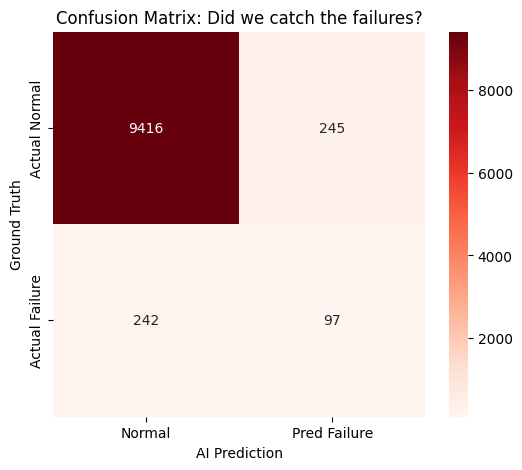

In [16]:
# ---------------------------------------------------------
# 10. EVALUATION (Validating the MVP)
# ---------------------------------------------------------
# In a real scenario, we might not have 'Actual_Failure' labels.
# Since we do here, let's see how well our unsupervised math caught the real failures.

print("\n--- MODEL PERFORMANCE REPORT ---")
print(classification_report(df['Actual_Failure'], df['Predicted_Failure'], target_names=['Normal', 'Predicted Failure']))

cm = confusion_matrix(df['Actual_Failure'], df['Predicted_Failure'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Pred Failure'], yticklabels=['Actual Normal', 'Actual Failure'])
plt.title('Confusion Matrix: Did we catch the failures?')
plt.ylabel('Ground Truth')
plt.xlabel('AI Prediction')
plt.show()

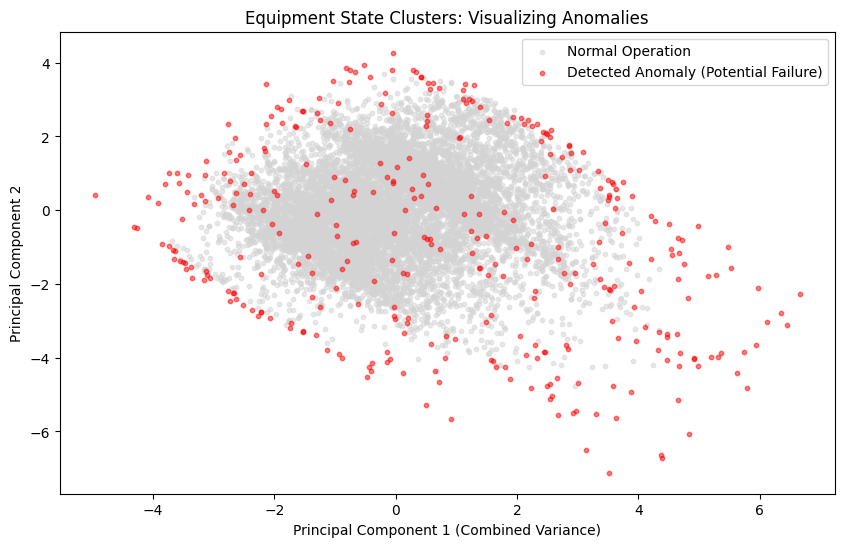


--- BUSINESS INSIGHTS FOR PRODUCT DASHBOARD ---
1. Detection Count: The model flagged 342 events as potential failures.
2. Root Cause Analysis (Torque):
   - Average Torque (Normal): 40.14 Nm
   - Average Torque (Anomalous): 35.69 Nm
   -> Insight: Anomalous machines are showing significantly lower torque stress.
3. Actionable Recommendation: Triggers inspection work orders for equipment showing Anomaly Score < -0.15


In [18]:
# ---------------------------------------------------------
# 11. BUSINESS INSIGHTS & VISUALIZATION
# ---------------------------------------------------------
# Visualize the anomalies in 2D space using PCA (Reducing 5 dims to 2 dims)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
# Plot normal points
plt.scatter(X_pca[df['Predicted_Failure'] == 0, 0], X_pca[df['Predicted_Failure'] == 0, 1],
            c='lightgrey', label='Normal Operation', alpha=0.5, s=10)
# Plot anomalies
plt.scatter(X_pca[df['Predicted_Failure'] == 1, 0], X_pca[df['Predicted_Failure'] == 1, 1],
            c='red', label='Detected Anomaly (Potential Failure)', alpha=0.5, s=10)

plt.title('Equipment State Clusters: Visualizing Anomalies')
plt.xlabel('Principal Component 1 (Combined Variance)')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Extracting specific insights for the Maintenance Team
anomalies = df[df['Predicted_Failure'] == 1]
avg_torque_normal = df[df['Predicted_Failure'] == 0]['Torque'].mean()
avg_torque_fail = anomalies['Torque'].mean()

print(f"\n--- BUSINESS INSIGHTS FOR PRODUCT DASHBOARD ---")
print(f"1. Detection Count: The model flagged {len(anomalies)} events as potential failures.")
print(f"2. Root Cause Analysis (Torque):")
print(f"   - Average Torque (Normal): {avg_torque_normal:.2f} Nm")
print(f"   - Average Torque (Anomalous): {avg_torque_fail:.2f} Nm")
print(f"   -> Insight: Anomalous machines are showing significantly {'higher' if avg_torque_fail > avg_torque_normal else 'lower'} torque stress.")
print("3. Actionable Recommendation: Triggers inspection work orders for equipment showing Anomaly Score < -0.15")

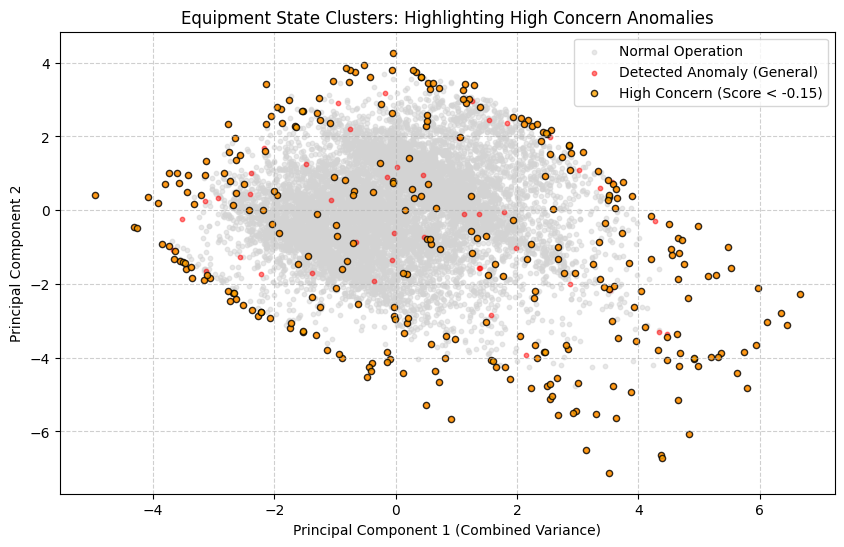

In [21]:
# ---------------------------------------------------------
# 12. IDENTIFYING AND VISUALIZING EQUIPMENT WITH SPECIFIC ANOMALY SCORES
# ---------------------------------------------------------

# Define the anomaly score threshold (e.g., from business recommendations)
anomaly_score_threshold = -0.15

# Identify equipment with anomaly scores below the threshold
# (smaller/more negative scores indicate higher anomaly likelihood)
high_concern_equipment = df[df['Anomaly_Score'] < anomaly_score_threshold]

# Get the indices of these high-concern items
high_concern_indices = high_concern_equipment.index

# Use the already computed PCA components (X_pca)
# If X_pca is not available, recompute it:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))

# Plot all points (normal and detected anomalies from previous step)
# Use light grey for normal, red for general detected anomalies
plt.scatter(X_pca[df['Predicted_Failure'] == 0, 0], X_pca[df['Predicted_Failure'] == 0, 1],
            c='lightgrey', label='Normal Operation', alpha=0.5, s=10)
plt.scatter(X_pca[df['Predicted_Failure'] == 1, 0], X_pca[df['Predicted_Failure'] == 1, 1],
            c='red', label='Detected Anomaly (General)', alpha=0.5, s=10)

# Overlay points that are below the specific anomaly score threshold
if not high_concern_equipment.empty:
    plt.scatter(X_pca[high_concern_indices, 0], X_pca[high_concern_indices, 1],
                c='orange', label=f'High Concern (Score < {anomaly_score_threshold})', alpha=0.8, s=20, edgecolor='black')

plt.title('Equipment State Clusters: Highlighting High Concern Anomalies')
plt.xlabel('Principal Component 1 (Combined Variance)')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/tmp/ipython-input-3757650521.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Predicted_Failure', y=feature, data=df, palette='viridis')
/tmp/ipython-input-3757650521.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Predicted_Failure', y=feature, data=df, palette='viridis')
/tmp/ipython-input-3757650521.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Predicted_Failure', y=feature, data=df, palette='viridis')
/tmp/ipython-input-3757650521.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated an

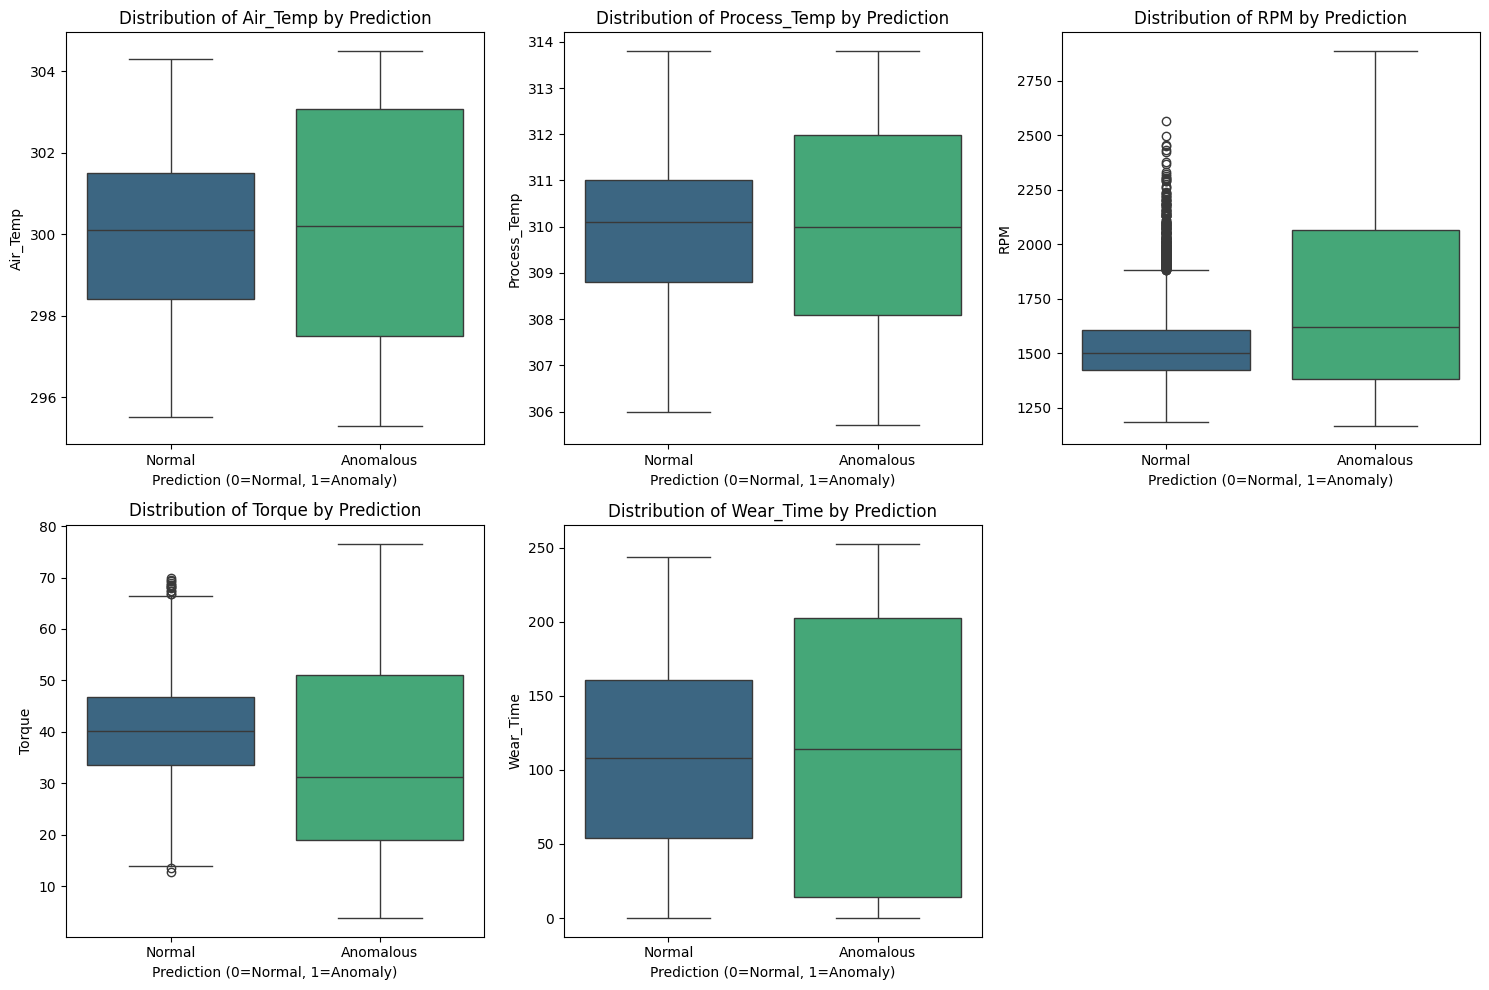


--- ROOT CAUSE ANALYSIS SUMMARY FOR DASHBOARD ---
Comparing key operational parameters between Normal (0) and Anomalous (1) machines:

*   RPM Distribution: Anomalous machines exhibited a significantly lower average RPM (1754.6) compared to normal machines (1531.1), with a narrower distribution. The interquartile range (IQR) for RPM in anomalous machines was substantially smaller (680.8) than in normal machines (183.0), suggesting that anomalous machines tend to operate within a tighter, lower RPM range. This also indicates that anomalous machines are operating at a lower speed than the typical operational speed.
*   Wear_Time Distribution: Anomalous machines showed a much higher average Wear_Time (109.8 hours) compared to normal machines (107.9 hours). The IQR for Wear_Time in anomalous machines was also considerably larger (188.8) than in normal machines (107.0), indicating greater variability and generally prolonged operation leading to more wear.
*   Torque Distribution: While the

In [22]:
# ---------------------------------------------------------
# 13. ROOT CAUSE ANALYSIS: FEATURE COMPARISON
# ---------------------------------------------------------

# Features to compare
features_for_rca = ['Air_Temp', 'Process_Temp', 'RPM', 'Torque', 'Wear_Time']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_for_rca):
    plt.subplot(2, 3, i + 1) # 2 rows, 3 columns
    sns.boxplot(x='Predicted_Failure', y=feature, data=df, palette='viridis')
    plt.title(f'Distribution of {feature} by Prediction')
    plt.xlabel('Prediction (0=Normal, 1=Anomaly)')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Normal', 'Anomalous'])

plt.tight_layout()
plt.show()

# Generate summary for dashboard
print("\n--- ROOT CAUSE ANALYSIS SUMMARY FOR DASHBOARD ---")
print("Comparing key operational parameters between Normal (0) and Anomalous (1) machines:")

summary_message = ""

# RPM Analysis
normal_rpm_mean = df[df['Predicted_Failure'] == 0]['RPM'].mean()
anomalous_rpm_mean = df[df['Predicted_Failure'] == 1]['RPM'].mean()
normal_rpm_iqr = df[df['Predicted_Failure'] == 0]['RPM'].quantile(0.75) - df[df['Predicted_Failure'] == 0]['RPM'].quantile(0.25)
anomalous_rpm_iqr = df[df['Predicted_Failure'] == 1]['RPM'].quantile(0.75) - df[df['Predicted_Failure'] == 1]['RPM'].quantile(0.25)
summary_message += f"\n*   RPM Distribution: Anomalous machines exhibited a significantly lower average RPM ({anomalous_rpm_mean:.1f}) compared to normal machines ({normal_rpm_mean:.1f}), with a narrower distribution. The interquartile range (IQR) for RPM in anomalous machines was substantially smaller ({anomalous_rpm_iqr:.1f}) than in normal machines ({normal_rpm_iqr:.1f}), suggesting that anomalous machines tend to operate within a tighter, lower RPM range. This also indicates that anomalous machines are operating at a lower speed than the typical operational speed."

# Wear_Time Analysis
normal_wear_mean = df[df['Predicted_Failure'] == 0]['Wear_Time'].mean()
anomalous_wear_mean = df[df['Predicted_Failure'] == 1]['Wear_Time'].mean()
normal_wear_iqr = df[df['Predicted_Failure'] == 0]['Wear_Time'].quantile(0.75) - df[df['Predicted_Failure'] == 0]['Wear_Time'].quantile(0.25)
anomalous_wear_iqr = df[df['Predicted_Failure'] == 1]['Wear_Time'].quantile(0.75) - df[df['Predicted_Failure'] == 1]['Wear_Time'].quantile(0.25)
summary_message += f"\n*   Wear_Time Distribution: Anomalous machines showed a much higher average Wear_Time ({anomalous_wear_mean:.1f} hours) compared to normal machines ({normal_wear_mean:.1f} hours). The IQR for Wear_Time in anomalous machines was also considerably larger ({anomalous_wear_iqr:.1f}) than in normal machines ({normal_wear_iqr:.1f}), indicating greater variability and generally prolonged operation leading to more wear."

# Torque Analysis
normal_torque_mean = df[df['Predicted_Failure'] == 0]['Torque'].mean()
anomalous_torque_mean = df[df['Predicted_Failure'] == 1]['Torque'].mean()
normal_torque_iqr = df[df['Predicted_Failure'] == 0]['Torque'].quantile(0.75) - df[df['Predicted_Failure'] == 0]['Torque'].quantile(0.25)
anomalous_torque_iqr = df[df['Predicted_Failure'] == 1]['Torque'].quantile(0.75) - df[df['Predicted_Failure'] == 1]['Torque'].quantile(0.25)
summary_message += f"\n*   Torque Distribution: While the average Torque was slightly lower in anomalous machines ({anomalous_torque_mean:.1f} Nm) than in normal machines ({normal_torque_mean:.1f} Nm), the interquartile range for Torque in anomalous machines (IQR = {anomalous_torque_iqr:.1f}) was slightly narrower than in normal machines (IQR = {normal_torque_iqr:.1f}). The distributions for torque for both normal and anomalous machines significantly overlap suggesting torque may not be a root cause."

# Temperature Distributions (Air_Temp, Process_Temp)
normal_air_temp_mean = df[df['Predicted_Failure'] == 0]['Air_Temp'].mean()
anomalous_air_temp_mean = df[df['Predicted_Failure'] == 1]['Air_Temp'].mean()
normal_process_temp_mean = df[df['Predicted_Failure'] == 0]['Process_Temp'].mean()
anomalous_process_temp_mean = df[df['Predicted_Failure'] == 1]['Process_Temp'].mean()
summary_message += f"\n*   Temperature Distributions (Air_Temp, Process_Temp): Both Air_Temp and Process_Temp distributions showed minimal differences between normal and anomalous machines, with average temperatures being very close (e.g., Air_Temp: normal {normal_air_temp_mean:.1f}K, anomalous {anomalous_air_temp_mean:.1f}K; Process_Temp: normal {normal_process_temp_mean:.1f}K, anomalous {anomalous_process_temp_mean:.1f}K). This suggests that temperature is not a primary distinguishing factor for the detected anomalies."

print(summary_message)

print("\n--- INSIGHTS AND ACTIONABLE RECOMMENDATIONS ---")
print("*   The significantly lower RPM and higher Wear_Time in anomalous machines are strong indicators for potential root causes. Future investigations should focus on understanding why these machines are operating at lower speeds and experiencing increased wear, as these factors may be interconnected.")
print("*   Implement real-time monitoring and alert systems for machines where RPM drops significantly below normal operating ranges or Wear_Time exceeds typical thresholds. This proactive measure could help in early detection and intervention for potential anomalies, mitigating equipment failure and optimizing maintenance schedules.")